In [92]:
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import Image
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier
import graphviz
import numpy as np
import pandas as pd
import pydotplus
import scipy.stats as stats
import timeit
from sklearn.utils import column_or_1d 
from sklearn.neighbors import KNeighborsClassifier

In [93]:
df = pd.read_excel("Telecom.xlsx")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data exploration & visualization

In [94]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


The % distribution of Gender is: 
Male      50.0
Female    50.0
Name: gender, dtype: float64


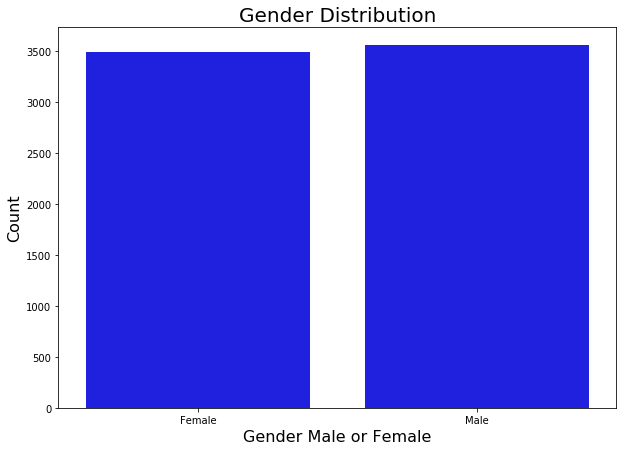

Male      3555
Female    3488
Name: gender, dtype: int64

In [95]:
# Gender 

print("The % distribution of Gender is: ")
print(round(df['gender'].value_counts(normalize=True),2)*100)

plt.figure(figsize=(10,7))

g = sns.countplot(df["gender"], color='blue')
g.set_title("Gender Distribution", fontsize=20)
g.set_ylabel('Count', fontsize=16)
g.set_xlabel('Gender Male or Female', fontsize=16)

plt.show()

df['gender'].value_counts()

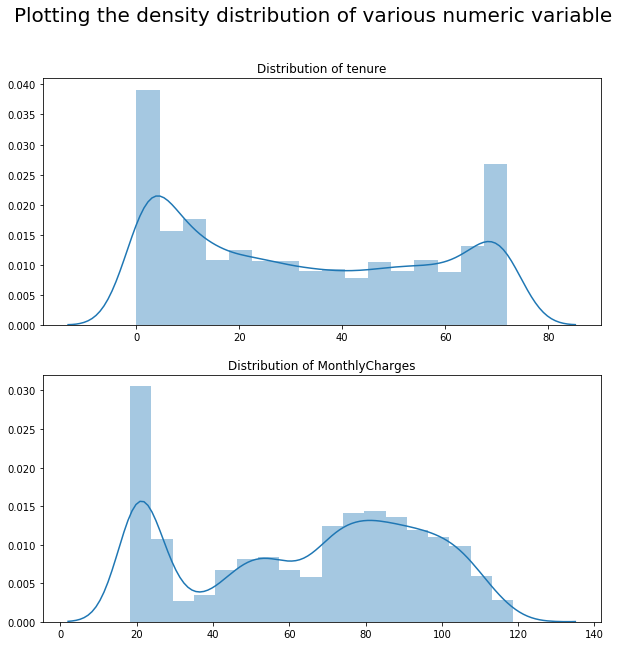

In [96]:
def draw_subplots(var_Name,tittle_Name,nrow=1,ncol=1,idx=1,fz=10): # Define a common module for drawing subplots.
    ax = plt.subplot(nrow,ncol,idx)                   #  idx - position of subplot in the main plotting window
    ax.set_title('Distribution of '+var_Name)         #  fz - the font size of Tittle in the main plotting window
    plt.suptitle(tittle_Name, fontsize=fz)

numeric_columns = ['tenure', 'MonthlyCharges']

fig,ax = plt.subplots(1,1, figsize=(10,10))
j=0  # reset the counter to plot 
title_Str="Plotting the density distribution of various numeric variable"

for i in numeric_columns:
    j +=1
    draw_subplots(i,title_Str,2,1,j,20) # create a 1x3 subplots for plotting distribution plots
    sns.distplot(df[i])
    plt.xlabel('')

# convert some categorical variables to numerical variables

In [97]:
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['MultipleLines'] = df['MultipleLines'].map({'No phone service': 2,'Yes': 1, 'No': 0})
df['InternetService'] = df['InternetService'].map({'DSL': 2,'Fiber optic': 1, 'No': 0})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['OnlineBackup'] = df['OnlineBackup'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['DeviceProtection'] = df['DeviceProtection'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['TechSupport'] = df['TechSupport'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['StreamingTV'] = df['StreamingTV'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['StreamingMovies'] = df['StreamingMovies'].map({'No internet service': 2,'Yes': 1, 'No': 0})
df['Contract'] = df['Contract'].map({'Two year': 2,'One year': 1, 'Month-to-month': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['PaymentMethod'] = df['PaymentMethod'].map({'Credit card (automatic)': 3,'Electronic check': 2,'Mailed check': 1, 'Bank transfer (automatic)': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,1,0,1,0,2,2,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,0,0,0,0,34,1,0,2,1,...,1,0,0,0,1,0,1,56.95,1889.5,0
2,3668-QPYBK,0,0,0,0,2,1,0,2,1,...,0,0,0,0,0,1,1,53.85,108.15,1
3,7795-CFOCW,0,0,0,0,45,0,2,2,1,...,1,1,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,1,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


# Holdout (splitting data)

In [98]:
x = df[['SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','Churn']]
y = df[['gender']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

# 1.Select Kbest

In [99]:
from sklearn import linear_model, decomposition, datasets
logistic = linear_model.LogisticRegression()
kbest = SelectKBest(chi2)
pca = decomposition.PCA()
pipe = Pipeline(steps=[('kbest', kbest), ('logistic', logistic)])

n_components = [3,4,5,6,7,8]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(kbest__k=n_components,
                              logistic__C=Cs))
aaa = estimator.fit(x_train, y_train)

print(" Best_score： %.4lf" %estimator.best_score_)

print(" Best_params：", estimator.best_params_)


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

 Best_score： 0.5004
 Best_params： {'kbest__k': 6, 'logistic__C': 0.0001}


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Here I got the result: the best k = 6.It means that we only keep six veriables. The next step is find out the six variables.

In [100]:
x_new = SelectKBest(score_func=chi2, k=6)
x_new.fit_transform(x_train, y_train)
print(x_new.get_support())

[False False False False False False  True  True False  True  True  True
 False False False False  True False]


Therefore, the six variables are:
'InternetService','OnlineSecurity','DeviceProtection','TechSupport','StreamingTV','MonthlyCharges'

In [101]:
X = df[['InternetService','OnlineSecurity','DeviceProtection','TechSupport','StreamingTV','MonthlyCharges']]
Y = df['gender']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

## Model 1: Decision Tree Model

### Criterion: Entropy (Information Gain)

In [102]:
start_time = timeit.default_timer()

for i in range(1,11,1):
    decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 0)
    decision_tree.fit(X_train,Y_train)

    dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    print('Depth: {}'.format(i))
    print('Model Performance: {:.2%}.\n'.format(cross_val_score(decision_tree, X_train, Y_train, cv=10).mean()))

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

Depth: 1
Model Performance: 50.79%.

Depth: 2
Model Performance: 50.13%.

Depth: 3
Model Performance: 50.44%.

Depth: 4
Model Performance: 49.92%.

Depth: 5
Model Performance: 51.26%.

Depth: 6
Model Performance: 50.67%.

Depth: 7
Model Performance: 50.37%.

Depth: 8
Model Performance: 50.32%.

Depth: 9
Model Performance: 49.96%.

Depth: 10
Model Performance: 50.29%.

--- Runtime: 15.698365538462895 seconds. ---


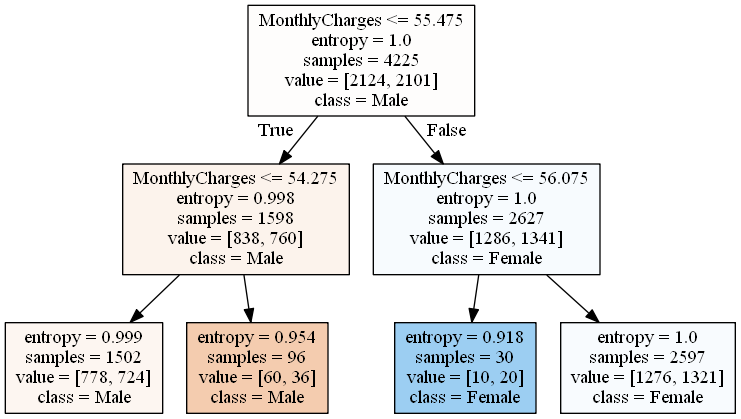

In [103]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [104]:
start_time = timeit.default_timer()

decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.34240410256461473 seconds. ---


### Cross validation

In [105]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores)

[0.52358491 0.53900709 0.48699764 0.49172577 0.50947867 0.50236967
 0.49526066 0.46445498 0.47393365 0.52606635]


### Classification_report and Confusion matrix

In [106]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5007097232079489
             precision    recall  f1-score   support

          0       0.39      0.51      0.44      1082
          1       0.62      0.49      0.55      1736

avg / total       0.53      0.50      0.51      2818

Confusion matrix:
[[553 878]
 [529 858]]


## Model 2: Random forest model

In [107]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

,feature,importance
0,MonthlyCharges,0.967912
1,OnlineSecurity,0.007375
2,TechSupport,0.007333
3,DeviceProtection,0.006828
4,StreamingTV,0.005396
5,InternetService,0.005157


In [108]:
start_time = timeit.default_timer()

rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.04838523076978163 seconds. ---


### Cross validation

In [109]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores)

[0.51886792 0.50827423 0.54846336 0.50591017 0.51658768 0.49052133
 0.492891   0.48578199 0.48104265 0.49052133]


### Classification_report and Confusion matrix

In [110]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.8403122782114976
             precision    recall  f1-score   support

          0       0.86      0.83      0.85      1489
          1       0.82      0.85      0.83      1329

avg / total       0.84      0.84      0.84      2818

Confusion matrix:
[[1235  196]
 [ 254 1133]]


## Model 3: KNN Classification 

In [111]:
neighbors = KNeighborsClassifier(n_neighbors=3)
model_neighbors = neighbors.fit(X_test, Y_test)

In [112]:
start_time = timeit.default_timer()

neighbors = KNeighborsClassifier(n_neighbors=3)
model_n = neighbors.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.004928000000290922 seconds. ---


### Cross validation

In [113]:
scores = cross_val_score(neighbors, X_train, Y_train, cv=10)
print(scores)

[0.51650943 0.47044917 0.4893617  0.4893617  0.50473934 0.52369668
 0.507109   0.45734597 0.52843602 0.49526066]


### Classification_report and Confusion matrix

In [114]:
Y_pred = model_neighbors.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.7097232079489
             precision    recall  f1-score   support

          0       0.75      0.70      0.72      1539
          1       0.67      0.72      0.69      1279

avg / total       0.71      0.71      0.71      2818

Confusion matrix:
[[1076  355]
 [ 463  924]]


## 4. Naive Bayes Classifier

In [115]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)

In [116]:
start_time = timeit.default_timer()

bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.00345312820354593 seconds. ---


### Cross validation

In [117]:
scores = cross_val_score(bayes, X_train, Y_train, cv=10)
print(scores)

[0.48584906 0.4822695  0.47754137 0.4893617  0.48578199 0.49526066
 0.51421801 0.51658768 0.45734597 0.46682464]


### Classification_report and Confusion matrix

In [118]:
Y_pred = model_bayes.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5010645848119234
             precision    recall  f1-score   support

          0       0.37      0.51      0.43      1031
          1       0.64      0.49      0.56      1787

avg / total       0.54      0.50      0.51      2818

Confusion matrix:
[[528 903]
 [503 884]]


## 5. Logistic regression

In [119]:
logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)

In [120]:
start_time = timeit.default_timer()

logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.00972389743583335 seconds. ---


### Cross validation

In [121]:
scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print(scores)

[0.49764151 0.4893617  0.47754137 0.5106383  0.48578199 0.50947867
 0.52369668 0.46208531 0.48578199 0.46445498]


### Classification_report and Confusion matrix

In [122]:
Y_pred = model_logreg.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5227111426543648
             precision    recall  f1-score   support

          0       0.60      0.53      0.56      1628
          1       0.44      0.52      0.48      1190

avg / total       0.53      0.52      0.53      2818

Confusion matrix:
[[857 574]
 [771 616]]


## 6. SVC

In [123]:
svc = SVC(kernel='linear')
model_svc = svc.fit(X_train, y_train)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [124]:
start_time = timeit.default_timer()

svc = SVC(kernel='linear')
model_sve = svc.fit(X_train, y_train)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Runtime: 3.0133981538456283 seconds. ---


### Cross validation

In [125]:
scores = cross_val_score(svc, X_train, Y_train, cv=10)
print(scores)

[0.50471698 0.47754137 0.46572104 0.47990544 0.50236967 0.47630332
 0.492891   0.46919431 0.48341232 0.46445498]


### Classification_report and Confusion matrix

In [126]:
Y_pred = model_svc.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.4978708303761533
             precision    recall  f1-score   support

          0       0.70      0.50      0.59      1980
          1       0.29      0.48      0.36       838

avg / total       0.58      0.50      0.52      2818

Confusion matrix:
[[998 433]
 [982 405]]


## 7. Gradient Boosting Classifiers

In [128]:
params = {'n_estimators': 500,
          'max_depth': 2}

gb = ensemble.GradientBoostingRegressor(**params)
model_gb = gb.fit(X_train, y_train)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [129]:
start_time = timeit.default_timer()

gb = ensemble.GradientBoostingRegressor(**params)
model_gb = gb.fit(X_train, y_train)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Runtime: 0.45423138461410417 seconds. ---


### Cross validation

In [130]:
scores = cross_val_score(gb, X_train, Y_train, cv=10)
print(scores)

[-0.05234826 -0.01365896 -0.04776588 -0.03180262 -0.0345525  -0.06360128
 -0.03449536 -0.02272582 -0.05174659 -0.05921452]


### Classification_report and Confusion matrix

In [132]:
Y_pred = model_gb.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

# PCA

In [55]:
from sklearn import linear_model, decomposition, datasets
from sklearn.decomposition import PCA

x = df[['SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','Churn']]
y = df[['gender']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

n_components = [3,4,5,6,7,8]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(x_train, y_train)

print(" Best_score： %.4lf" %estimator.best_score_)

print(" Best_params：", estimator.best_params_)


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

 Best_score： 0.5148
 Best_params： {'logistic__C': 1.0, 'pca__n_components': 3}


Here I got the result: pca__n_components = 3.It means that we now have three new features.

In [64]:
pca = PCA(n_components=3)
x_transformed = pd.DataFrame(pca.fit_transform(x))
X_train, X_test, Y_train, Y_test = train_test_split(x_transformed, y, test_size=0.4, random_state=0)
print(x_transformed)

              0          1         2
0    -44.878700 -13.621108  2.732213
1     -6.351884   4.753345  1.462628
2    -22.768442 -22.905422  1.034693
3    -14.933509  20.947100  2.347339
4     -7.506836 -30.087243  0.700479
5     21.212651 -36.899691 -1.214992
6     17.634514 -19.766472 -0.049559
7    -41.154562  -5.438664  2.879718
8     34.370934 -20.976122 -1.291403
9      4.831076  30.420376  2.074602
10   -21.604811 -11.300100  1.706284
11   -48.482613   4.778350 -1.915692
12    43.122027   8.057632 -0.199538
13    42.300665  -1.520097 -0.888648
14    33.707178 -23.971202 -1.889157
15    59.439919  12.611396 -1.536375
16   -31.641552  36.591788 -1.171851
17    54.373330  17.170008 -0.774237
18   -18.137732 -16.237026  1.186144
19    18.051645 -21.062914 -0.695572
20   -36.021304 -17.784563  1.995664
21   -49.427179   0.793105 -2.150793
22   -53.793227  -9.347211 -2.197851
23     6.550401  25.229083  2.141796
24     2.419811  17.188335  1.619134
25    -9.549677   1.810823  1.535911
2

## Model 1: Decision Tree Model

### Criterion: Entropy (Information Gain)

In [66]:
start_time = timeit.default_timer()

for i in range(1,11,1):
    decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 0)
    decision_tree.fit(X_train,Y_train)

    dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    print('Depth: {}'.format(i))
    print('Model Performance: {:.2%}.\n'.format(cross_val_score(decision_tree, X_train, Y_train, cv=10).mean()))

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

Depth: 1
Model Performance: 50.06%.

Depth: 2
Model Performance: 49.61%.

Depth: 3
Model Performance: 49.44%.

Depth: 4
Model Performance: 50.91%.

Depth: 5
Model Performance: 50.70%.

Depth: 6
Model Performance: 49.80%.

Depth: 7
Model Performance: 50.65%.

Depth: 8
Model Performance: 50.86%.

Depth: 9
Model Performance: 50.27%.

Depth: 10
Model Performance: 50.58%.

--- Runtime: 16.371190564103017 seconds. ---


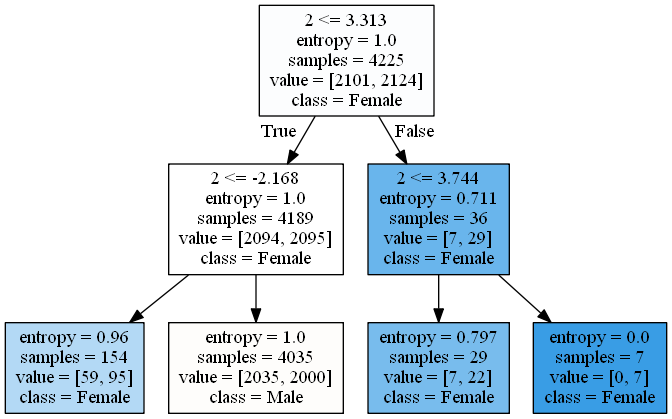

In [65]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [67]:
start_time = timeit.default_timer()

decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.3744500512821105 seconds. ---


### Cross validation

In [68]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores)

[0.50471698 0.49881797 0.49408983 0.49881797 0.49526066 0.48815166
 0.49763033 0.50236967 0.48341232 0.49763033]


### Classification_report and Confusion matrix

In [69]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.49609652235628104
             precision    recall  f1-score   support

     Female       0.95      0.49      0.65      2675
       Male       0.05      0.54      0.10       143

avg / total       0.91      0.50      0.62      2818

Confusion matrix:
[[1321   66]
 [1354   77]]


## Model 2: Random forest model

In [70]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

C:\Users\mzz00\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,feature,importance
0,1,0.338559
1,0,0.335852
2,2,0.325588


### Cross validation

In [71]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

[0.50235849 0.47044917 0.5035461  0.47990544 0.52132701 0.5
 0.50473934 0.50236967 0.53554502 0.51421801]


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


### Classification_report and Confusion matrix

In [72]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.9680624556422995
             precision    recall  f1-score   support

     Female       0.99      0.95      0.97      1437
       Male       0.95      0.99      0.97      1381

avg / total       0.97      0.97      0.97      2818

Confusion matrix:
[[1367   20]
 [  70 1361]]


## Model 3: KNN Classification

In [73]:
neighbors = KNeighborsClassifier(n_neighbors=3)
model_neighbors = neighbors.fit(X_test, Y_test)

C:\Users\mzz00\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [74]:
start_time = timeit.default_timer()

neighbors = KNeighborsClassifier(n_neighbors=3)
model_n = neighbors.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.0075425641025503865 seconds. ---


C:\Users\mzz00\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### Cross validation

In [75]:
scores = cross_val_score(neighbors, X_train, Y_train, cv=10)
print(scores)

[0.47641509 0.51536643 0.52245863 0.47044917 0.49763033 0.48104265
 0.51658768 0.492891   0.53080569 0.51658768]


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

### Classification_report and Confusion matrix

In [76]:
Y_pred = model_neighbors.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.7498225691980128
             precision    recall  f1-score   support

     Female       0.73      0.75      0.74      1352
       Male       0.77      0.75      0.76      1466

avg / total       0.75      0.75      0.75      2818

Confusion matrix:
[[1017  370]
 [ 335 1096]]


## 4. Naive Bayes Classifier

In [77]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
start_time = timeit.default_timer()

bayes = GaussianNB()
model_bayes = bayes.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.0075786666666317615 seconds. ---


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [79]:
scores = cross_val_score(bayes, X_train, Y_train, cv=10)
print(scores)

[0.5        0.50118203 0.49881797 0.4964539  0.47156398 0.53080569
 0.51895735 0.5        0.49052133 0.54739336]


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

### Classification_report and Confusion matrix

In [80]:
Y_pred = model_bayes.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5255500354861604
             precision    recall  f1-score   support

     Female       0.33      0.53      0.41       870
       Male       0.71      0.52      0.60      1948

avg / total       0.60      0.53      0.54      2818

Confusion matrix:
[[ 460  927]
 [ 410 1021]]


## 5. Logistic regression

In [81]:
logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
start_time = timeit.default_timer()

logreg = LogisticRegression()
model_logreg = logreg.fit(X_test, Y_test)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.009719384614982118 seconds. ---


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Cross validation

In [83]:
scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print(scores)

[0.52122642 0.52718676 0.5035461  0.52009456 0.48815166 0.53317536
 0.52132701 0.507109   0.46208531 0.52369668]


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

### Classification_report and Confusion matrix

In [84]:
Y_pred = model_logreg.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.517388218594748
             precision    recall  f1-score   support

     Female       0.28      0.52      0.37       757
       Male       0.74      0.52      0.61      2061

avg / total       0.62      0.52      0.54      2818

Confusion matrix:
[[ 392  995]
 [ 365 1066]]


## 6. SVC

In [85]:
svc = SVC(kernel='linear')
model_svc = svc.fit(X_train, y_train)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
start_time = timeit.default_timer()

svc = SVC(kernel='linear')
model_sve = svc.fit(X_train, y_train)
print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Runtime: 3.638205538461989 seconds. ---


### Cross validation

In [87]:
scores = cross_val_score(svc, X_train, Y_train, cv=10)
print(scores)

C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[0.50471698 0.50591017 0.50827423 0.5035461  0.51184834 0.5
 0.51421801 0.50473934 0.47393365 0.52843602]


### Classification_report and Confusion matrix

In [88]:
Y_pred = model_svc.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.5031937544357701
             precision    recall  f1-score   support

     Female       0.52      0.50      0.51      1447
       Male       0.49      0.51      0.50      1371

avg / total       0.50      0.50      0.50      2818

Confusion matrix:
[[717 670]
 [730 701]]


## 7. Gradient Boosting Classifiers